In [1]:
% load_ext autoreload
% autoreload 2

In [2]:
import numpy as np
import lightkurve as lk
import threemultis

/Users/ch/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tpf = lk.search_targetpixelfile('K2-168').download()
tpf = tpf[tpf.to_lightcurve().normalize().flux > 0.8]
mask = threemultis.utils.planet_mask(tpf.time, 'K2-168')

In [4]:
aper = np.nanmedian(tpf.flux, axis=0) > 30

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [5]:
# First pass, remove some very bad outliers
bad = np.zeros(len(tpf.time), bool)
for count in range(2):
    pld_lc = tpf[~bad].to_corrector('pld').correct(aperture_mask=aper, cadence_mask=mask[~bad])
    pld_lc = pld_lc.flatten(31, mask=~mask[~bad])
    bad |= np.in1d(tpf.time, pld_lc.time[np.abs(pld_lc.flux - 1) > 5 * np.std(pld_lc.flux - 1)])
    
tpf = tpf[~bad]
mask = mask[~bad]

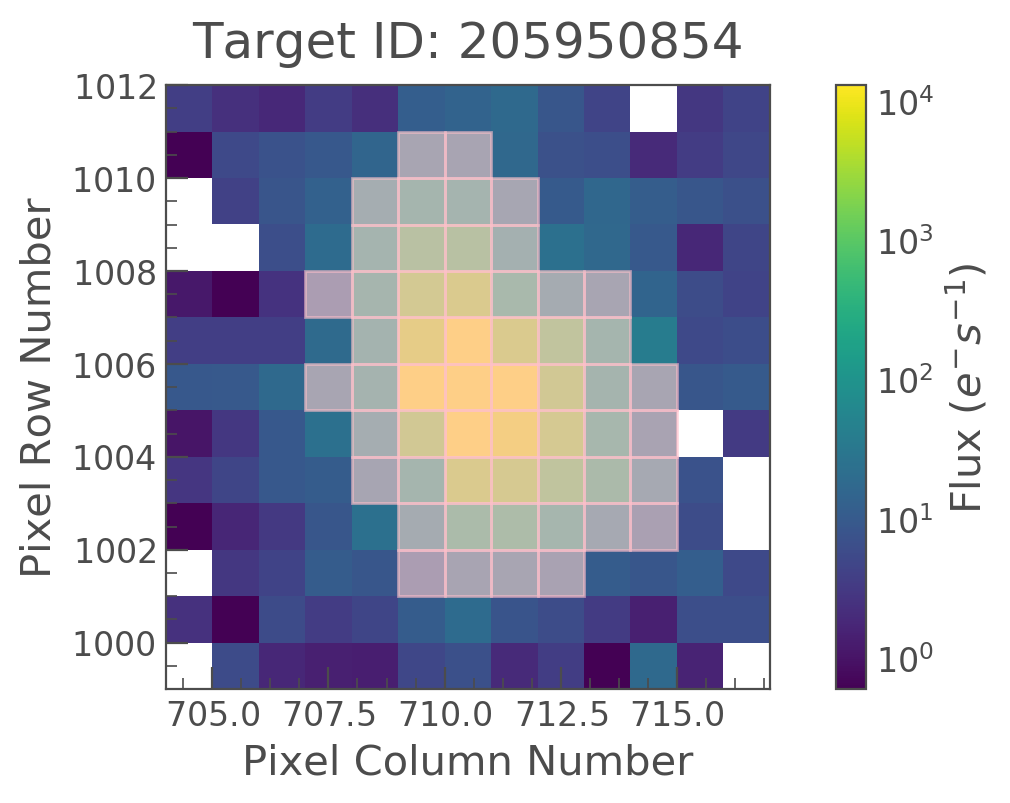

In [6]:
tpf.plot(scale='log', aperture_mask=aper)

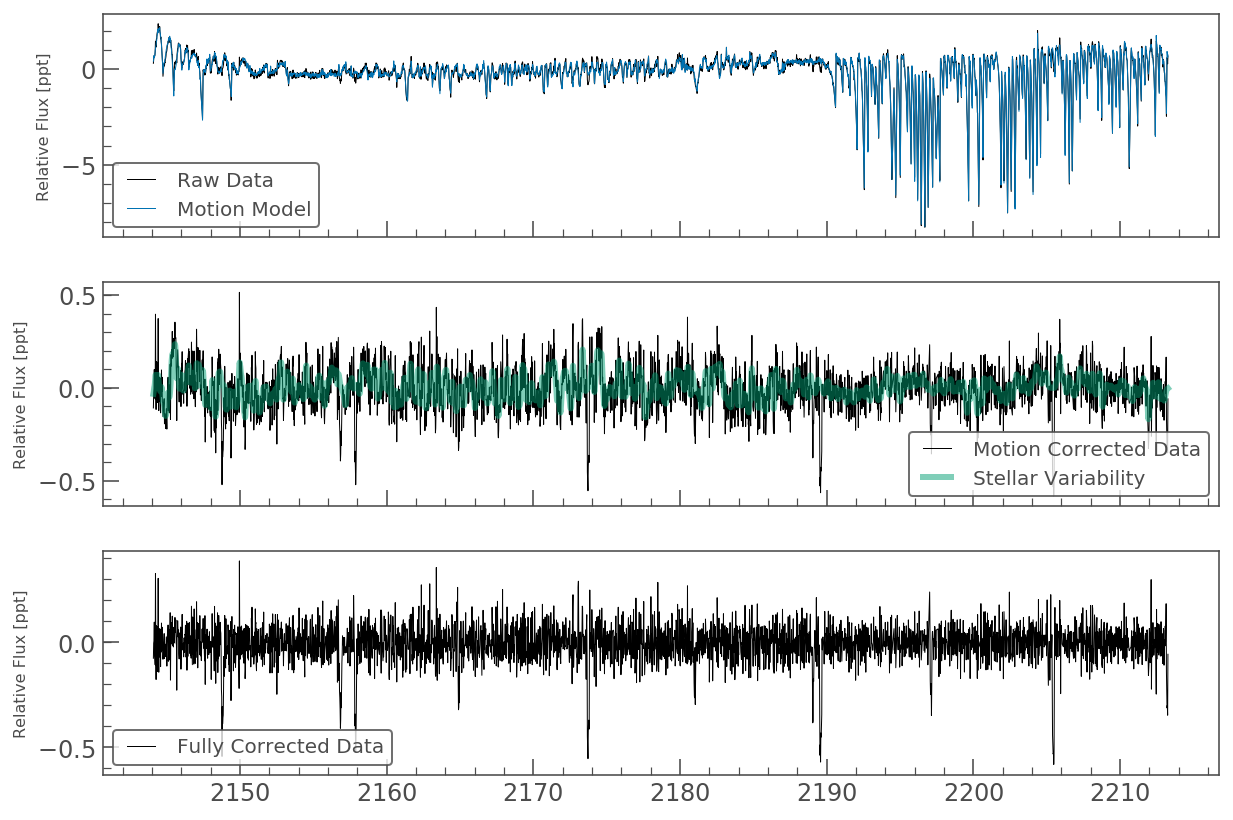

In [15]:
clc = threemultis.fit.PLD(tpf, planet_mask=mask, return_quick_corrected=True, aperture=aper)

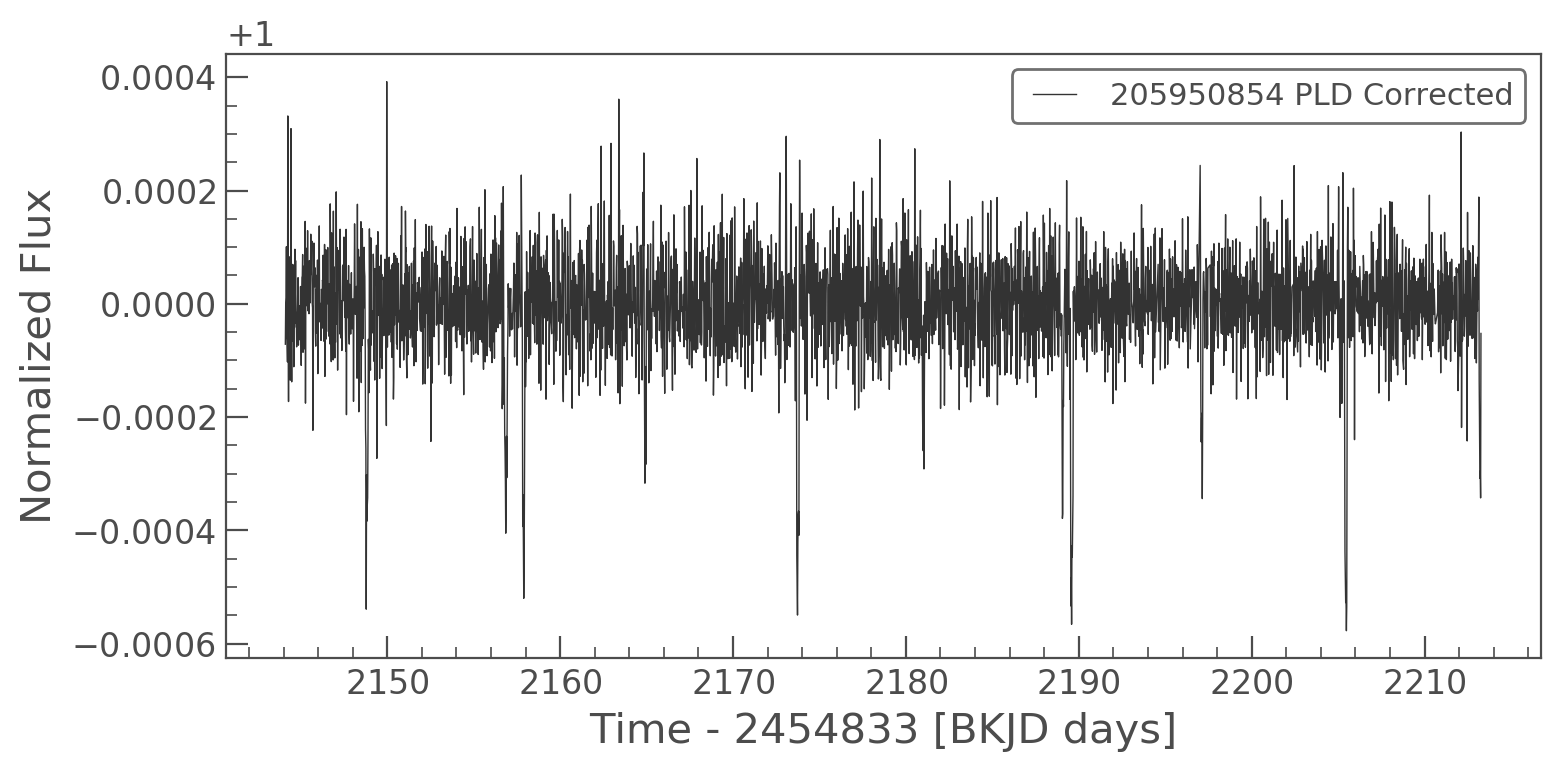

In [16]:
clc.plot()

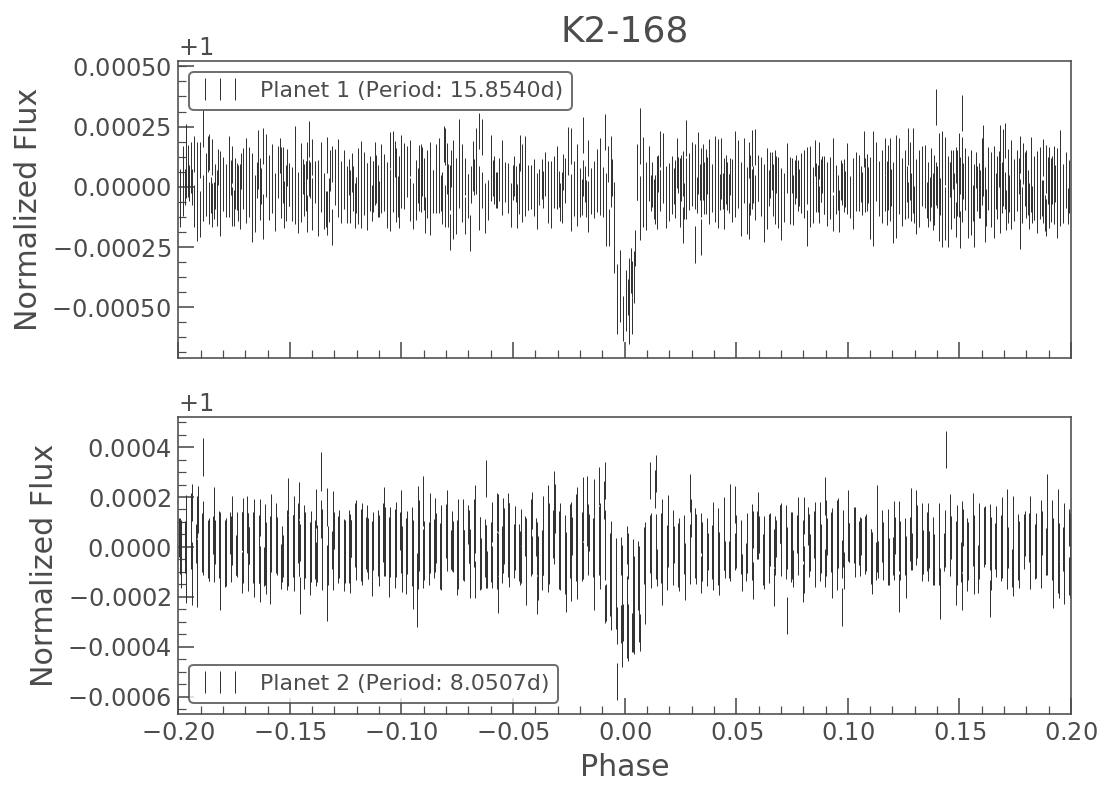

In [17]:
threemultis.utils.planet_plot(clc, 'K2-168');

In [11]:
params = threemultis.utils.get_params('K2-168')

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


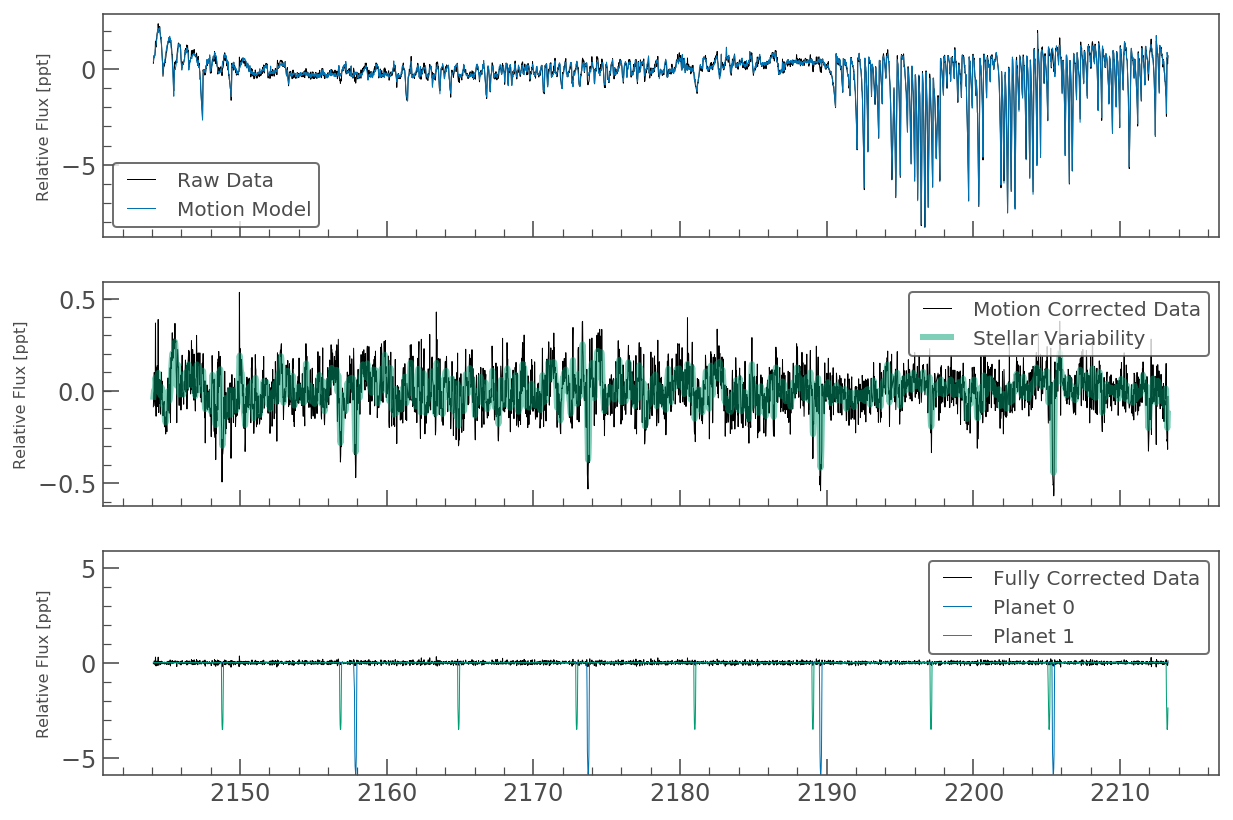

In [12]:
clc = threemultis.fit.joint_fit(tpf, period_value=list(params['Period']),
                                            t0_value=list(params['T0']), depth_value=list(params['Depth']),
                                            duration_value=list(params['T0']),
                                            R_star=(params.loc[0, 'R_star'], params.loc[0, 'R_star_error']),
                                            M_star=(params.loc[0, 'M_star'], params.loc[0, 'M_star_error']),
                                            T_star=(params.loc[0, 'T_star'], params.loc[0, 'T_star_error']),
                                           aperture=aper, return_quick_corrected=True)

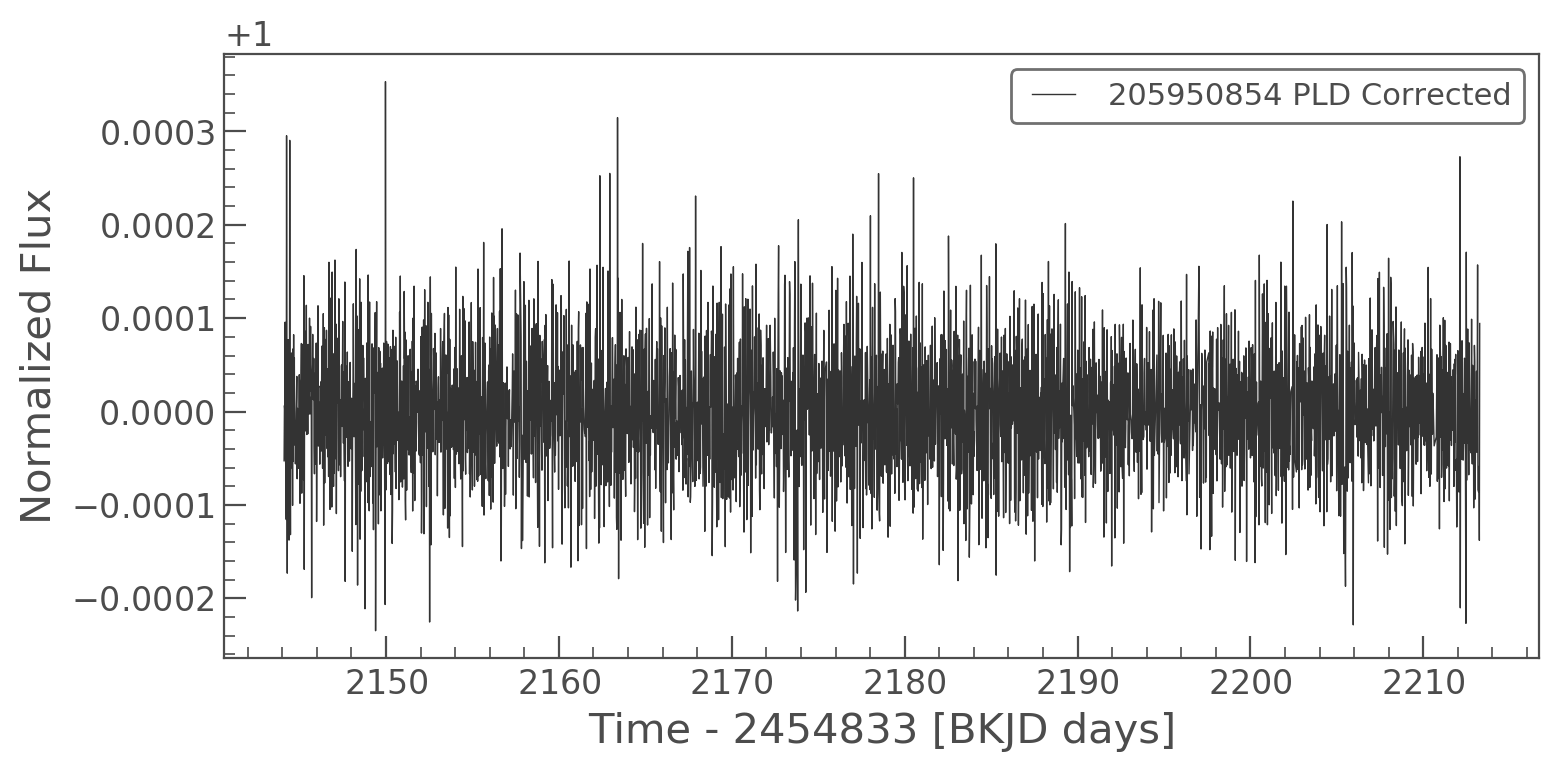

In [13]:
clc.plot()

In [ ]:
threemultis.utils.planet_plot(clc, 'K2-168');